# 오전

### GAN

In [235]:
# GAN
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [7]:
if not os.path.exists("./GAN_images"):
    os.mkdir("./GAN_images")

In [15]:
# 생성자 모델 만들기 : pooling 안 함
generator = Sequential()
generator.add(Dense(128 * 7 * 7, input_dim = 100, activation = LeakyReLU(0.2)))
generator.add(BatchNormalization()) # 정규화 => 분산이 1이 되도록 재배치
generator.add(Reshape((7, 7, 128))) # 배열 reshape
generator.add(UpSampling2D()) # 사이즈 업
generator.add(Conv2D(64, kernel_size = 5, padding = "same"))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D()) # 사이즈 업
generator.add(Conv2D(1, kernel_size = 5, padding = "same", activation = "tanh"))

In [21]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_3 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)      

In [19]:
# 판별자 모델 # 학습 안 함
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28, 28, 1),
                        padding = "same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding = "same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = "sigmoid"))
discriminator.compile(loss = "BCE", optimizer = "adam")
discriminator.trainable = False # 학습 하면 안돼!!

In [22]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_3 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_4 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)            

In [23]:
# 생성자와 판별자 모델을 연결시키는 GAN 모델 생성
ginput = Input(shape = (100, ))
goutput = discriminator(generator(ginput))
gan = Model(ginput, goutput)
gan.compile(loss = "BCE", optimizer = "adam")

In [52]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_6 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_10 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [49]:
# 실제로 신경망을 실행시키는 함수를 정의
def gan_train(epoch, batch_size, saving_interval):
    # mnist 데이터 불러오기
    (x_train, _), (_, _) = mnist.load_data() # train의 이미지만
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32")
    # tanh를 사용하기 위해 픽셀 값이 0 ~ 255 => -1 ~ 1로 변환
    x_train = (x_train - 127.5) / 127.5
    
    # 실제 데이터와 가상 데이터의 타겟 생성 (y)
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    # 생성된 이미지와 실제 이미지 비교 학습 (epoch 만큼)
    for i in range(epoch):
        # 실제 이미지를 판별자에 입력
        idx = np.random.randint(0, x_train.shape[0], batch_size) # 인덱스 random
        imgs = x_train[idx] # 이미지를 랜덤하게 batch_size만큼 가져옴
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        # 가상 이미지를 판별자에 입력
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        # 판별자와 생성자의 오차 계산
        d_loss = np.add(d_loss_real, d_loss_fake) / 2
        g_loss = gan.train_on_batch(noise, true)
        
        # 오차 출력
        print("epoch : %d" % i, " d_loss : %.4f" % d_loss, " g_loss : %.4f" % g_loss)
        
        # 이미지 중간과정을 저장 : 5 * 5 이미지를 저장
        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
            gen_imgs = gen_imgs * 0.5 + 0.5
            
            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap = "gray")
                    axs[j, k].axis("off")
                    count += 1
            fig.savefig("GAN_images/gan_mnist_%d.png" % i)

epoch : 0 
 d_loss : 0.4741 
 g_loss : 0.0535
epoch : 1 
 d_loss : 0.4526 
 g_loss : 0.1325
epoch : 2 
 d_loss : 0.4409 
 g_loss : 0.2387
epoch : 3 
 d_loss : 0.4668 
 g_loss : 0.2757
epoch : 4 
 d_loss : 0.4623 
 g_loss : 0.2406
epoch : 5 
 d_loss : 0.4581 
 g_loss : 0.2154
epoch : 6 
 d_loss : 0.4236 
 g_loss : 0.2460
epoch : 7 
 d_loss : 0.3809 
 g_loss : 0.3650
epoch : 8 
 d_loss : 0.3301 
 g_loss : 0.6407
epoch : 9 
 d_loss : 0.3159 
 g_loss : 0.8491
epoch : 10 
 d_loss : 0.2831 
 g_loss : 0.9004
epoch : 11 
 d_loss : 0.2805 
 g_loss : 0.7881
epoch : 12 
 d_loss : 0.3088 
 g_loss : 0.6108
epoch : 13 
 d_loss : 0.3428 
 g_loss : 0.6702
epoch : 14 
 d_loss : 0.3630 
 g_loss : 1.1760
epoch : 15 
 d_loss : 0.3264 
 g_loss : 0.2643
epoch : 16 
 d_loss : 0.1508 
 g_loss : 0.0149
epoch : 17 
 d_loss : 0.0467 
 g_loss : 0.0015
epoch : 18 
 d_loss : 0.0146 
 g_loss : 0.0002
epoch : 19 
 d_loss : 0.0054 
 g_loss : 0.0055
epoch : 20 
 d_loss : 0.0029 
 g_loss : 0.0044
epoch : 21 
 d_loss : 0

epoch : 173 
 d_loss : 0.4353 
 g_loss : 1.4611
epoch : 174 
 d_loss : 0.4005 
 g_loss : 1.3323
epoch : 175 
 d_loss : 0.4508 
 g_loss : 1.5083
epoch : 176 
 d_loss : 0.4235 
 g_loss : 1.4780
epoch : 177 
 d_loss : 0.4139 
 g_loss : 1.9161
epoch : 178 
 d_loss : 0.5533 
 g_loss : 1.5689
epoch : 179 
 d_loss : 0.5073 
 g_loss : 1.5180
epoch : 180 
 d_loss : 0.5188 
 g_loss : 1.6028
epoch : 181 
 d_loss : 0.6111 
 g_loss : 1.6428
epoch : 182 
 d_loss : 0.4982 
 g_loss : 1.8679
epoch : 183 
 d_loss : 0.7986 
 g_loss : 1.3548
epoch : 184 
 d_loss : 0.6353 
 g_loss : 1.6891
epoch : 185 
 d_loss : 0.8053 
 g_loss : 1.3951
epoch : 186 
 d_loss : 1.0007 
 g_loss : 1.2637
epoch : 187 
 d_loss : 1.1512 
 g_loss : 1.3596
epoch : 188 
 d_loss : 1.1182 
 g_loss : 1.2093
epoch : 189 
 d_loss : 0.8668 
 g_loss : 1.2326
epoch : 190 
 d_loss : 0.7696 
 g_loss : 1.6849
epoch : 191 
 d_loss : 0.8279 
 g_loss : 1.9421
epoch : 192 
 d_loss : 0.7433 
 g_loss : 1.8184
epoch : 193 
 d_loss : 0.8049 
 g_loss :

epoch : 344 
 d_loss : 0.3165 
 g_loss : 2.1235
epoch : 345 
 d_loss : 0.3563 
 g_loss : 2.2660
epoch : 346 
 d_loss : 0.3248 
 g_loss : 2.1191
epoch : 347 
 d_loss : 0.4127 
 g_loss : 2.1508
epoch : 348 
 d_loss : 0.5014 
 g_loss : 1.8314
epoch : 349 
 d_loss : 0.3217 
 g_loss : 2.0951
epoch : 350 
 d_loss : 0.4780 
 g_loss : 2.0624
epoch : 351 
 d_loss : 0.3885 
 g_loss : 2.2529
epoch : 352 
 d_loss : 0.4262 
 g_loss : 1.6836
epoch : 353 
 d_loss : 0.5055 
 g_loss : 1.5118
epoch : 354 
 d_loss : 0.5691 
 g_loss : 1.5107
epoch : 355 
 d_loss : 0.5689 
 g_loss : 1.7342
epoch : 356 
 d_loss : 0.4254 
 g_loss : 2.3397
epoch : 357 
 d_loss : 0.5608 
 g_loss : 1.5989
epoch : 358 
 d_loss : 0.4445 
 g_loss : 1.7976
epoch : 359 
 d_loss : 0.4980 
 g_loss : 1.5880
epoch : 360 
 d_loss : 0.4525 
 g_loss : 1.7438
epoch : 361 
 d_loss : 0.5609 
 g_loss : 1.9495
epoch : 362 
 d_loss : 0.5135 
 g_loss : 1.7619
epoch : 363 
 d_loss : 0.7045 
 g_loss : 1.5497
epoch : 364 
 d_loss : 0.5147 
 g_loss :

epoch : 515 
 d_loss : 0.4124 
 g_loss : 2.1460
epoch : 516 
 d_loss : 0.4642 
 g_loss : 1.8786
epoch : 517 
 d_loss : 0.3817 
 g_loss : 1.6732
epoch : 518 
 d_loss : 0.3131 
 g_loss : 1.9315
epoch : 519 
 d_loss : 0.2701 
 g_loss : 2.2649
epoch : 520 
 d_loss : 0.2742 
 g_loss : 2.3585
epoch : 521 
 d_loss : 0.3432 
 g_loss : 2.3244
epoch : 522 
 d_loss : 0.2691 
 g_loss : 2.4635
epoch : 523 
 d_loss : 0.2325 
 g_loss : 2.5025
epoch : 524 
 d_loss : 0.2481 
 g_loss : 2.1967
epoch : 525 
 d_loss : 0.3190 
 g_loss : 2.1483
epoch : 526 
 d_loss : 0.2980 
 g_loss : 2.2890
epoch : 527 
 d_loss : 0.2577 
 g_loss : 2.1001
epoch : 528 
 d_loss : 0.1591 
 g_loss : 2.4983
epoch : 529 
 d_loss : 0.1986 
 g_loss : 2.4626
epoch : 530 
 d_loss : 0.2434 
 g_loss : 2.1329
epoch : 531 
 d_loss : 0.2801 
 g_loss : 2.1670
epoch : 532 
 d_loss : 0.2072 
 g_loss : 2.6858
epoch : 533 
 d_loss : 0.1631 
 g_loss : 2.6372
epoch : 534 
 d_loss : 0.2077 
 g_loss : 2.5717
epoch : 535 
 d_loss : 0.2968 
 g_loss :

epoch : 686 
 d_loss : 0.5491 
 g_loss : 1.2469
epoch : 687 
 d_loss : 0.7674 
 g_loss : 1.7170
epoch : 688 
 d_loss : 0.4411 
 g_loss : 1.5353
epoch : 689 
 d_loss : 0.2939 
 g_loss : 1.9563
epoch : 690 
 d_loss : 0.3356 
 g_loss : 2.1926
epoch : 691 
 d_loss : 0.3336 
 g_loss : 2.1757
epoch : 692 
 d_loss : 0.4464 
 g_loss : 1.5880
epoch : 693 
 d_loss : 0.2937 
 g_loss : 1.4381
epoch : 694 
 d_loss : 0.4886 
 g_loss : 1.4997
epoch : 695 
 d_loss : 0.2195 
 g_loss : 2.0066
epoch : 696 
 d_loss : 0.2877 
 g_loss : 2.0620
epoch : 697 
 d_loss : 0.3458 
 g_loss : 1.8322
epoch : 698 
 d_loss : 0.3828 
 g_loss : 2.6762
epoch : 699 
 d_loss : 0.2496 
 g_loss : 2.4375
epoch : 700 
 d_loss : 0.6309 
 g_loss : 2.1599
epoch : 701 
 d_loss : 0.8324 
 g_loss : 2.0629
epoch : 702 
 d_loss : 0.7166 
 g_loss : 2.3162
epoch : 703 
 d_loss : 0.5573 
 g_loss : 2.8404
epoch : 704 
 d_loss : 0.6551 
 g_loss : 2.7374
epoch : 705 
 d_loss : 0.6865 
 g_loss : 2.0223
epoch : 706 
 d_loss : 0.6290 
 g_loss :

epoch : 857 
 d_loss : 0.5339 
 g_loss : 1.3161
epoch : 858 
 d_loss : 0.3699 
 g_loss : 1.5762
epoch : 859 
 d_loss : 0.4153 
 g_loss : 1.3277
epoch : 860 
 d_loss : 0.5518 
 g_loss : 1.4924
epoch : 861 
 d_loss : 0.6145 
 g_loss : 1.2145
epoch : 862 
 d_loss : 0.3301 
 g_loss : 1.6466
epoch : 863 
 d_loss : 0.5610 
 g_loss : 1.4673
epoch : 864 
 d_loss : 0.7263 
 g_loss : 1.3888
epoch : 865 
 d_loss : 0.5223 
 g_loss : 1.2274
epoch : 866 
 d_loss : 0.4518 
 g_loss : 1.4464
epoch : 867 
 d_loss : 0.4654 
 g_loss : 1.4370
epoch : 868 
 d_loss : 0.4814 
 g_loss : 1.2842
epoch : 869 
 d_loss : 0.2707 
 g_loss : 1.6568
epoch : 870 
 d_loss : 0.3855 
 g_loss : 1.8338
epoch : 871 
 d_loss : 0.3710 
 g_loss : 1.9378
epoch : 872 
 d_loss : 0.3093 
 g_loss : 2.5324
epoch : 873 
 d_loss : 0.2743 
 g_loss : 1.9646
epoch : 874 
 d_loss : 0.4882 
 g_loss : 1.7657
epoch : 875 
 d_loss : 0.2976 
 g_loss : 1.9462
epoch : 876 
 d_loss : 0.3189 
 g_loss : 2.2865
epoch : 877 
 d_loss : 0.2395 
 g_loss :

epoch : 1028 
 d_loss : 0.3857 
 g_loss : 3.0123
epoch : 1029 
 d_loss : 0.4886 
 g_loss : 2.2096
epoch : 1030 
 d_loss : 0.4395 
 g_loss : 2.2791
epoch : 1031 
 d_loss : 0.3800 
 g_loss : 1.9360
epoch : 1032 
 d_loss : 0.4642 
 g_loss : 2.0160
epoch : 1033 
 d_loss : 0.4101 
 g_loss : 1.7571
epoch : 1034 
 d_loss : 0.4305 
 g_loss : 1.6648
epoch : 1035 
 d_loss : 0.3788 
 g_loss : 2.0789
epoch : 1036 
 d_loss : 0.4451 
 g_loss : 2.4114
epoch : 1037 
 d_loss : 0.4963 
 g_loss : 1.9918
epoch : 1038 
 d_loss : 0.4413 
 g_loss : 2.3126
epoch : 1039 
 d_loss : 0.5972 
 g_loss : 1.5171
epoch : 1040 
 d_loss : 0.5753 
 g_loss : 1.9988
epoch : 1041 
 d_loss : 0.6743 
 g_loss : 1.7923
epoch : 1042 
 d_loss : 0.4092 
 g_loss : 1.9167
epoch : 1043 
 d_loss : 0.5196 
 g_loss : 1.6185
epoch : 1044 
 d_loss : 0.5238 
 g_loss : 1.7209
epoch : 1045 
 d_loss : 0.4288 
 g_loss : 1.6896
epoch : 1046 
 d_loss : 0.4746 
 g_loss : 1.7945
epoch : 1047 
 d_loss : 0.4757 
 g_loss : 1.4767
epoch : 1048 
 d_los

epoch : 1196 
 d_loss : 0.4078 
 g_loss : 2.0086
epoch : 1197 
 d_loss : 0.3666 
 g_loss : 2.3078
epoch : 1198 
 d_loss : 0.4045 
 g_loss : 2.1489
epoch : 1199 
 d_loss : 0.4343 
 g_loss : 1.9826
epoch : 1200 
 d_loss : 0.4414 
 g_loss : 1.8044
epoch : 1201 
 d_loss : 0.5441 
 g_loss : 1.4361
epoch : 1202 
 d_loss : 0.4359 
 g_loss : 1.8431
epoch : 1203 
 d_loss : 0.3299 
 g_loss : 1.8679
epoch : 1204 
 d_loss : 0.4835 
 g_loss : 2.1762
epoch : 1205 
 d_loss : 0.4183 
 g_loss : 2.4993
epoch : 1206 
 d_loss : 0.2878 
 g_loss : 2.6195
epoch : 1207 
 d_loss : 0.5055 
 g_loss : 1.7320
epoch : 1208 
 d_loss : 0.4738 
 g_loss : 1.7545
epoch : 1209 
 d_loss : 0.3557 
 g_loss : 1.7652
epoch : 1210 
 d_loss : 0.2912 
 g_loss : 2.4093
epoch : 1211 
 d_loss : 0.4515 
 g_loss : 2.2288
epoch : 1212 
 d_loss : 0.3391 
 g_loss : 2.4382
epoch : 1213 
 d_loss : 0.3853 
 g_loss : 1.9493
epoch : 1214 
 d_loss : 0.3768 
 g_loss : 1.7960
epoch : 1215 
 d_loss : 0.2763 
 g_loss : 1.9707
epoch : 1216 
 d_los

epoch : 1364 
 d_loss : 0.4670 
 g_loss : 2.2414
epoch : 1365 
 d_loss : 0.5337 
 g_loss : 1.9115
epoch : 1366 
 d_loss : 0.5674 
 g_loss : 2.0136
epoch : 1367 
 d_loss : 0.5516 
 g_loss : 1.6308
epoch : 1368 
 d_loss : 0.3730 
 g_loss : 2.2548
epoch : 1369 
 d_loss : 0.6404 
 g_loss : 1.8851
epoch : 1370 
 d_loss : 0.5843 
 g_loss : 1.7369
epoch : 1371 
 d_loss : 0.4514 
 g_loss : 2.1182
epoch : 1372 
 d_loss : 0.5382 
 g_loss : 2.1210
epoch : 1373 
 d_loss : 0.3478 
 g_loss : 2.6938
epoch : 1374 
 d_loss : 0.5325 
 g_loss : 2.3976
epoch : 1375 
 d_loss : 0.4847 
 g_loss : 1.9759
epoch : 1376 
 d_loss : 0.4120 
 g_loss : 1.8924
epoch : 1377 
 d_loss : 0.4672 
 g_loss : 2.0074
epoch : 1378 
 d_loss : 0.4171 
 g_loss : 2.2629
epoch : 1379 
 d_loss : 0.2593 
 g_loss : 3.0578
epoch : 1380 
 d_loss : 0.3053 
 g_loss : 2.7179
epoch : 1381 
 d_loss : 0.3253 
 g_loss : 2.2911
epoch : 1382 
 d_loss : 0.3118 
 g_loss : 2.3051
epoch : 1383 
 d_loss : 0.2406 
 g_loss : 2.5701
epoch : 1384 
 d_los

epoch : 1532 
 d_loss : 0.4037 
 g_loss : 1.7633
epoch : 1533 
 d_loss : 0.2792 
 g_loss : 1.9978
epoch : 1534 
 d_loss : 0.4985 
 g_loss : 1.7215
epoch : 1535 
 d_loss : 0.4187 
 g_loss : 2.0817
epoch : 1536 
 d_loss : 0.3200 
 g_loss : 1.9937
epoch : 1537 
 d_loss : 0.4002 
 g_loss : 1.8660
epoch : 1538 
 d_loss : 0.3382 
 g_loss : 1.9188
epoch : 1539 
 d_loss : 0.4142 
 g_loss : 1.9686
epoch : 1540 
 d_loss : 0.3361 
 g_loss : 1.8466
epoch : 1541 
 d_loss : 0.3598 
 g_loss : 2.2733
epoch : 1542 
 d_loss : 0.3248 
 g_loss : 2.3162
epoch : 1543 
 d_loss : 0.3597 
 g_loss : 1.8967
epoch : 1544 
 d_loss : 0.4259 
 g_loss : 2.1958
epoch : 1545 
 d_loss : 0.3735 
 g_loss : 1.7588
epoch : 1546 
 d_loss : 0.4810 
 g_loss : 1.6891
epoch : 1547 
 d_loss : 0.3872 
 g_loss : 1.8378
epoch : 1548 
 d_loss : 0.5381 
 g_loss : 1.7119
epoch : 1549 
 d_loss : 0.4457 
 g_loss : 2.2168
epoch : 1550 
 d_loss : 0.5042 
 g_loss : 1.7600
epoch : 1551 
 d_loss : 0.4344 
 g_loss : 1.7357
epoch : 1552 
 d_los

epoch : 1700 
 d_loss : 0.5086 
 g_loss : 1.5346
epoch : 1701 
 d_loss : 0.4852 
 g_loss : 2.1394
epoch : 1702 
 d_loss : 0.4935 
 g_loss : 2.2585
epoch : 1703 
 d_loss : 0.4925 
 g_loss : 2.2774
epoch : 1704 
 d_loss : 0.4421 
 g_loss : 2.1980
epoch : 1705 
 d_loss : 0.5259 
 g_loss : 1.6764
epoch : 1706 
 d_loss : 0.4617 
 g_loss : 1.5038
epoch : 1707 
 d_loss : 0.5292 
 g_loss : 1.4355
epoch : 1708 
 d_loss : 0.4876 
 g_loss : 2.0343
epoch : 1709 
 d_loss : 0.5010 
 g_loss : 2.1360
epoch : 1710 
 d_loss : 0.4167 
 g_loss : 2.6644
epoch : 1711 
 d_loss : 0.3953 
 g_loss : 2.7507
epoch : 1712 
 d_loss : 0.3758 
 g_loss : 2.1823
epoch : 1713 
 d_loss : 0.4068 
 g_loss : 2.1800
epoch : 1714 
 d_loss : 0.5852 
 g_loss : 1.6792
epoch : 1715 
 d_loss : 0.3038 
 g_loss : 1.6693
epoch : 1716 
 d_loss : 0.3255 
 g_loss : 2.1032
epoch : 1717 
 d_loss : 0.3805 
 g_loss : 2.0235
epoch : 1718 
 d_loss : 0.4123 
 g_loss : 2.4837
epoch : 1719 
 d_loss : 0.3582 
 g_loss : 2.2406
epoch : 1720 
 d_los

epoch : 1868 
 d_loss : 0.3780 
 g_loss : 1.7912
epoch : 1869 
 d_loss : 0.3913 
 g_loss : 1.7948
epoch : 1870 
 d_loss : 0.3570 
 g_loss : 1.6981
epoch : 1871 
 d_loss : 0.4668 
 g_loss : 1.6637
epoch : 1872 
 d_loss : 0.4118 
 g_loss : 1.7085
epoch : 1873 
 d_loss : 0.3844 
 g_loss : 1.9955
epoch : 1874 
 d_loss : 0.4521 
 g_loss : 1.5652
epoch : 1875 
 d_loss : 0.3735 
 g_loss : 1.9354
epoch : 1876 
 d_loss : 0.4284 
 g_loss : 1.5405
epoch : 1877 
 d_loss : 0.3872 
 g_loss : 1.9392
epoch : 1878 
 d_loss : 0.3706 
 g_loss : 1.7727
epoch : 1879 
 d_loss : 0.4602 
 g_loss : 1.8003
epoch : 1880 
 d_loss : 0.3965 
 g_loss : 1.8901
epoch : 1881 
 d_loss : 0.4455 
 g_loss : 1.7141
epoch : 1882 
 d_loss : 0.5098 
 g_loss : 1.5724
epoch : 1883 
 d_loss : 0.3803 
 g_loss : 1.9771
epoch : 1884 
 d_loss : 0.5200 
 g_loss : 1.3739
epoch : 1885 
 d_loss : 0.4570 
 g_loss : 1.7059
epoch : 1886 
 d_loss : 0.6418 
 g_loss : 1.3813
epoch : 1887 
 d_loss : 0.4480 
 g_loss : 1.7491
epoch : 1888 
 d_los

epoch : 2036 
 d_loss : 0.6274 
 g_loss : 1.4137
epoch : 2037 
 d_loss : 0.3671 
 g_loss : 1.5729
epoch : 2038 
 d_loss : 0.5375 
 g_loss : 1.4510
epoch : 2039 
 d_loss : 0.4762 
 g_loss : 1.5011
epoch : 2040 
 d_loss : 0.5559 
 g_loss : 1.6034
epoch : 2041 
 d_loss : 0.5143 
 g_loss : 1.7501
epoch : 2042 
 d_loss : 0.4105 
 g_loss : 1.8508
epoch : 2043 
 d_loss : 0.5563 
 g_loss : 1.6357
epoch : 2044 
 d_loss : 0.4837 
 g_loss : 1.7173
epoch : 2045 
 d_loss : 0.4883 
 g_loss : 1.4336
epoch : 2046 
 d_loss : 0.5674 
 g_loss : 1.3450
epoch : 2047 
 d_loss : 0.4357 
 g_loss : 1.4490
epoch : 2048 
 d_loss : 0.5076 
 g_loss : 1.4261
epoch : 2049 
 d_loss : 0.4534 
 g_loss : 1.6676
epoch : 2050 
 d_loss : 0.4583 
 g_loss : 1.7687
epoch : 2051 
 d_loss : 0.5589 
 g_loss : 1.6754
epoch : 2052 
 d_loss : 0.4999 
 g_loss : 1.4585
epoch : 2053 
 d_loss : 0.4815 
 g_loss : 1.7335
epoch : 2054 
 d_loss : 0.3762 
 g_loss : 2.0883
epoch : 2055 
 d_loss : 0.4416 
 g_loss : 2.1156
epoch : 2056 
 d_los

epoch : 2204 
 d_loss : 0.4707 
 g_loss : 1.7396
epoch : 2205 
 d_loss : 0.4966 
 g_loss : 1.9788
epoch : 2206 
 d_loss : 0.4212 
 g_loss : 1.8427
epoch : 2207 
 d_loss : 0.5987 
 g_loss : 1.6780
epoch : 2208 
 d_loss : 0.4691 
 g_loss : 1.5840
epoch : 2209 
 d_loss : 0.4404 
 g_loss : 1.5849
epoch : 2210 
 d_loss : 0.5405 
 g_loss : 1.6577
epoch : 2211 
 d_loss : 0.4496 
 g_loss : 1.8832
epoch : 2212 
 d_loss : 0.3700 
 g_loss : 2.0035
epoch : 2213 
 d_loss : 0.4177 
 g_loss : 1.6447
epoch : 2214 
 d_loss : 0.4730 
 g_loss : 1.6273
epoch : 2215 
 d_loss : 0.4678 
 g_loss : 1.7150
epoch : 2216 
 d_loss : 0.7174 
 g_loss : 1.4077
epoch : 2217 
 d_loss : 0.4798 
 g_loss : 1.6301
epoch : 2218 
 d_loss : 0.4749 
 g_loss : 1.5513
epoch : 2219 
 d_loss : 0.4337 
 g_loss : 2.2227
epoch : 2220 
 d_loss : 0.5318 
 g_loss : 1.7437
epoch : 2221 
 d_loss : 0.5160 
 g_loss : 1.4008
epoch : 2222 
 d_loss : 0.5789 
 g_loss : 1.1155
epoch : 2223 
 d_loss : 0.5141 
 g_loss : 1.2890
epoch : 2224 
 d_los

epoch : 2372 
 d_loss : 0.5356 
 g_loss : 1.7082
epoch : 2373 
 d_loss : 0.5204 
 g_loss : 1.6708
epoch : 2374 
 d_loss : 0.5192 
 g_loss : 1.3773
epoch : 2375 
 d_loss : 0.4869 
 g_loss : 1.5064
epoch : 2376 
 d_loss : 0.5253 
 g_loss : 1.2299
epoch : 2377 
 d_loss : 0.4778 
 g_loss : 1.3047
epoch : 2378 
 d_loss : 0.4346 
 g_loss : 1.5472
epoch : 2379 
 d_loss : 0.5478 
 g_loss : 1.6602
epoch : 2380 
 d_loss : 0.4993 
 g_loss : 1.8693
epoch : 2381 
 d_loss : 0.4624 
 g_loss : 1.9096
epoch : 2382 
 d_loss : 0.5130 
 g_loss : 1.6052
epoch : 2383 
 d_loss : 0.5673 
 g_loss : 1.6688
epoch : 2384 
 d_loss : 0.4330 
 g_loss : 1.4944
epoch : 2385 
 d_loss : 0.4105 
 g_loss : 1.7172
epoch : 2386 
 d_loss : 0.5086 
 g_loss : 1.6691
epoch : 2387 
 d_loss : 0.5797 
 g_loss : 1.4279
epoch : 2388 
 d_loss : 0.3806 
 g_loss : 1.9611
epoch : 2389 
 d_loss : 0.4723 
 g_loss : 1.6336
epoch : 2390 
 d_loss : 0.5489 
 g_loss : 1.8742
epoch : 2391 
 d_loss : 0.4043 
 g_loss : 1.8416
epoch : 2392 
 d_los

epoch : 2540 
 d_loss : 0.4550 
 g_loss : 1.2261
epoch : 2541 
 d_loss : 0.3647 
 g_loss : 1.5690
epoch : 2542 
 d_loss : 0.4671 
 g_loss : 1.9272
epoch : 2543 
 d_loss : 0.3679 
 g_loss : 1.7262
epoch : 2544 
 d_loss : 0.4318 
 g_loss : 1.6313
epoch : 2545 
 d_loss : 0.4466 
 g_loss : 1.5353
epoch : 2546 
 d_loss : 0.5131 
 g_loss : 2.0701
epoch : 2547 
 d_loss : 0.5404 
 g_loss : 1.5154
epoch : 2548 
 d_loss : 0.5419 
 g_loss : 2.0724
epoch : 2549 
 d_loss : 0.3483 
 g_loss : 1.5676
epoch : 2550 
 d_loss : 0.4434 
 g_loss : 1.8630
epoch : 2551 
 d_loss : 0.4793 
 g_loss : 1.7063
epoch : 2552 
 d_loss : 0.5309 
 g_loss : 1.7477
epoch : 2553 
 d_loss : 0.5008 
 g_loss : 1.4380
epoch : 2554 
 d_loss : 0.5871 
 g_loss : 1.4030
epoch : 2555 
 d_loss : 0.6528 
 g_loss : 1.6442
epoch : 2556 
 d_loss : 0.6398 
 g_loss : 1.5596
epoch : 2557 
 d_loss : 0.5503 
 g_loss : 1.4999
epoch : 2558 
 d_loss : 0.6079 
 g_loss : 1.6353
epoch : 2559 
 d_loss : 0.5666 
 g_loss : 1.6610
epoch : 2560 
 d_los

epoch : 2708 
 d_loss : 0.4925 
 g_loss : 1.1479
epoch : 2709 
 d_loss : 0.5559 
 g_loss : 1.3306
epoch : 2710 
 d_loss : 0.5409 
 g_loss : 1.2108
epoch : 2711 
 d_loss : 0.4970 
 g_loss : 1.5300
epoch : 2712 
 d_loss : 0.3632 
 g_loss : 1.6794
epoch : 2713 
 d_loss : 0.4629 
 g_loss : 1.8470
epoch : 2714 
 d_loss : 0.4536 
 g_loss : 1.8194
epoch : 2715 
 d_loss : 0.4799 
 g_loss : 1.5550
epoch : 2716 
 d_loss : 0.4312 
 g_loss : 1.4369
epoch : 2717 
 d_loss : 0.4431 
 g_loss : 1.3255
epoch : 2718 
 d_loss : 0.5067 
 g_loss : 1.5212
epoch : 2719 
 d_loss : 0.4016 
 g_loss : 1.6481
epoch : 2720 
 d_loss : 0.4666 
 g_loss : 1.6605
epoch : 2721 
 d_loss : 0.4157 
 g_loss : 1.4977
epoch : 2722 
 d_loss : 0.3876 
 g_loss : 1.6967
epoch : 2723 
 d_loss : 0.3664 
 g_loss : 1.7917
epoch : 2724 
 d_loss : 0.3857 
 g_loss : 1.7609
epoch : 2725 
 d_loss : 0.4486 
 g_loss : 1.7985
epoch : 2726 
 d_loss : 0.3929 
 g_loss : 1.5357
epoch : 2727 
 d_loss : 0.4100 
 g_loss : 1.3243
epoch : 2728 
 d_los

epoch : 2876 
 d_loss : 0.6507 
 g_loss : 1.7668
epoch : 2877 
 d_loss : 0.4122 
 g_loss : 1.2829
epoch : 2878 
 d_loss : 0.5512 
 g_loss : 1.6677
epoch : 2879 
 d_loss : 0.5083 
 g_loss : 1.7827
epoch : 2880 
 d_loss : 0.3743 
 g_loss : 2.0409
epoch : 2881 
 d_loss : 0.6463 
 g_loss : 1.9606
epoch : 2882 
 d_loss : 0.6009 
 g_loss : 1.3557
epoch : 2883 
 d_loss : 0.6087 
 g_loss : 1.3139
epoch : 2884 
 d_loss : 0.5117 
 g_loss : 1.5372
epoch : 2885 
 d_loss : 0.3977 
 g_loss : 1.7206
epoch : 2886 
 d_loss : 0.3969 
 g_loss : 1.8587
epoch : 2887 
 d_loss : 0.5817 
 g_loss : 1.6712
epoch : 2888 
 d_loss : 0.4483 
 g_loss : 1.8920
epoch : 2889 
 d_loss : 0.5656 
 g_loss : 1.5978
epoch : 2890 
 d_loss : 0.5490 
 g_loss : 1.6089
epoch : 2891 
 d_loss : 0.4972 
 g_loss : 1.4676
epoch : 2892 
 d_loss : 0.4199 
 g_loss : 1.3644
epoch : 2893 
 d_loss : 0.5776 
 g_loss : 1.5521
epoch : 2894 
 d_loss : 0.4904 
 g_loss : 1.8532
epoch : 2895 
 d_loss : 0.5126 
 g_loss : 1.6290
epoch : 2896 
 d_los

epoch : 3044 
 d_loss : 0.5755 
 g_loss : 1.4010
epoch : 3045 
 d_loss : 0.6515 
 g_loss : 0.9880
epoch : 3046 
 d_loss : 0.3976 
 g_loss : 1.2943
epoch : 3047 
 d_loss : 0.4618 
 g_loss : 1.4700
epoch : 3048 
 d_loss : 0.4990 
 g_loss : 1.7412
epoch : 3049 
 d_loss : 0.5305 
 g_loss : 1.6797
epoch : 3050 
 d_loss : 0.5568 
 g_loss : 1.7165
epoch : 3051 
 d_loss : 0.3965 
 g_loss : 1.3775
epoch : 3052 
 d_loss : 0.4192 
 g_loss : 1.6808
epoch : 3053 
 d_loss : 0.5453 
 g_loss : 1.5423
epoch : 3054 
 d_loss : 0.4749 
 g_loss : 1.7001
epoch : 3055 
 d_loss : 0.4891 
 g_loss : 1.3127
epoch : 3056 
 d_loss : 0.5794 
 g_loss : 1.4414
epoch : 3057 
 d_loss : 0.3206 
 g_loss : 1.9555
epoch : 3058 
 d_loss : 0.3678 
 g_loss : 1.9456
epoch : 3059 
 d_loss : 0.3877 
 g_loss : 2.0004
epoch : 3060 
 d_loss : 0.3536 
 g_loss : 1.8757
epoch : 3061 
 d_loss : 0.3958 
 g_loss : 1.5231
epoch : 3062 
 d_loss : 0.3610 
 g_loss : 1.7618
epoch : 3063 
 d_loss : 0.5618 
 g_loss : 1.4540
epoch : 3064 
 d_los

epoch : 3212 
 d_loss : 0.4874 
 g_loss : 1.5106
epoch : 3213 
 d_loss : 0.5829 
 g_loss : 1.7646
epoch : 3214 
 d_loss : 0.5235 
 g_loss : 1.3734
epoch : 3215 
 d_loss : 0.6686 
 g_loss : 1.2247
epoch : 3216 
 d_loss : 0.4785 
 g_loss : 1.6965
epoch : 3217 
 d_loss : 0.5543 
 g_loss : 1.4104
epoch : 3218 
 d_loss : 0.5634 
 g_loss : 1.6199
epoch : 3219 
 d_loss : 0.5206 
 g_loss : 1.6812
epoch : 3220 
 d_loss : 0.5452 
 g_loss : 1.2685
epoch : 3221 
 d_loss : 0.5057 
 g_loss : 1.4439
epoch : 3222 
 d_loss : 0.4447 
 g_loss : 1.5682
epoch : 3223 
 d_loss : 0.4245 
 g_loss : 1.9926
epoch : 3224 
 d_loss : 0.4089 
 g_loss : 1.9712
epoch : 3225 
 d_loss : 0.4283 
 g_loss : 1.8167
epoch : 3226 
 d_loss : 0.3848 
 g_loss : 1.8832
epoch : 3227 
 d_loss : 0.4668 
 g_loss : 1.8368
epoch : 3228 
 d_loss : 0.4448 
 g_loss : 1.7836
epoch : 3229 
 d_loss : 0.4430 
 g_loss : 1.5705
epoch : 3230 
 d_loss : 0.4729 
 g_loss : 1.6482
epoch : 3231 
 d_loss : 0.4636 
 g_loss : 1.5625
epoch : 3232 
 d_los

epoch : 3380 
 d_loss : 0.4784 
 g_loss : 1.7635
epoch : 3381 
 d_loss : 0.5256 
 g_loss : 1.2996
epoch : 3382 
 d_loss : 0.6614 
 g_loss : 1.2243
epoch : 3383 
 d_loss : 0.4926 
 g_loss : 1.5219
epoch : 3384 
 d_loss : 0.6044 
 g_loss : 1.4904
epoch : 3385 
 d_loss : 0.6174 
 g_loss : 1.2534
epoch : 3386 
 d_loss : 0.6014 
 g_loss : 1.4978
epoch : 3387 
 d_loss : 0.5353 
 g_loss : 1.4475
epoch : 3388 
 d_loss : 0.6260 
 g_loss : 1.5674
epoch : 3389 
 d_loss : 0.6329 
 g_loss : 1.4987
epoch : 3390 
 d_loss : 0.5601 
 g_loss : 1.7458
epoch : 3391 
 d_loss : 0.4938 
 g_loss : 1.4793
epoch : 3392 
 d_loss : 0.4799 
 g_loss : 1.6479
epoch : 3393 
 d_loss : 0.4481 
 g_loss : 1.7656
epoch : 3394 
 d_loss : 0.6137 
 g_loss : 1.5586
epoch : 3395 
 d_loss : 0.5894 
 g_loss : 1.4627
epoch : 3396 
 d_loss : 0.5483 
 g_loss : 1.5652
epoch : 3397 
 d_loss : 0.5993 
 g_loss : 1.5343
epoch : 3398 
 d_loss : 0.6372 
 g_loss : 1.1604
epoch : 3399 
 d_loss : 0.4848 
 g_loss : 1.8559
epoch : 3400 
 d_los

epoch : 3548 
 d_loss : 0.3996 
 g_loss : 1.7369
epoch : 3549 
 d_loss : 0.5091 
 g_loss : 1.5101
epoch : 3550 
 d_loss : 0.4720 
 g_loss : 1.5940
epoch : 3551 
 d_loss : 0.3468 
 g_loss : 1.9600
epoch : 3552 
 d_loss : 0.3370 
 g_loss : 2.0207
epoch : 3553 
 d_loss : 0.4604 
 g_loss : 1.7349
epoch : 3554 
 d_loss : 0.5089 
 g_loss : 1.9286
epoch : 3555 
 d_loss : 0.4299 
 g_loss : 1.8886
epoch : 3556 
 d_loss : 0.4535 
 g_loss : 1.2333
epoch : 3557 
 d_loss : 0.3565 
 g_loss : 1.4258
epoch : 3558 
 d_loss : 0.6818 
 g_loss : 1.1654
epoch : 3559 
 d_loss : 0.5529 
 g_loss : 1.8500
epoch : 3560 
 d_loss : 0.5544 
 g_loss : 2.1040
epoch : 3561 
 d_loss : 0.5649 
 g_loss : 1.6333
epoch : 3562 
 d_loss : 0.5962 
 g_loss : 1.3809
epoch : 3563 
 d_loss : 0.6437 
 g_loss : 1.2560
epoch : 3564 
 d_loss : 0.4332 
 g_loss : 1.2861
epoch : 3565 
 d_loss : 0.4764 
 g_loss : 1.5478
epoch : 3566 
 d_loss : 0.4797 
 g_loss : 1.7961
epoch : 3567 
 d_loss : 0.6645 
 g_loss : 2.0663
epoch : 3568 
 d_los

epoch : 3716 
 d_loss : 0.5430 
 g_loss : 1.2936
epoch : 3717 
 d_loss : 0.3676 
 g_loss : 1.6075
epoch : 3718 
 d_loss : 0.5000 
 g_loss : 1.6847
epoch : 3719 
 d_loss : 0.4489 
 g_loss : 1.6393
epoch : 3720 
 d_loss : 0.3587 
 g_loss : 1.9133
epoch : 3721 
 d_loss : 0.5811 
 g_loss : 1.4647
epoch : 3722 
 d_loss : 0.4705 
 g_loss : 1.3842
epoch : 3723 
 d_loss : 0.4498 
 g_loss : 1.5337
epoch : 3724 
 d_loss : 0.5022 
 g_loss : 1.3274
epoch : 3725 
 d_loss : 0.5119 
 g_loss : 1.5741
epoch : 3726 
 d_loss : 0.5257 
 g_loss : 1.7790
epoch : 3727 
 d_loss : 0.4172 
 g_loss : 1.8040
epoch : 3728 
 d_loss : 0.4352 
 g_loss : 1.7870
epoch : 3729 
 d_loss : 0.4747 
 g_loss : 1.3614
epoch : 3730 
 d_loss : 0.4668 
 g_loss : 1.5833
epoch : 3731 
 d_loss : 0.3996 
 g_loss : 1.4740
epoch : 3732 
 d_loss : 0.3402 
 g_loss : 2.4319
epoch : 3733 
 d_loss : 0.3869 
 g_loss : 2.3020
epoch : 3734 
 d_loss : 0.7147 
 g_loss : 2.1660
epoch : 3735 
 d_loss : 0.5726 
 g_loss : 1.7352
epoch : 3736 
 d_los

epoch : 3884 
 d_loss : 0.3875 
 g_loss : 1.4698
epoch : 3885 
 d_loss : 0.4781 
 g_loss : 1.6001
epoch : 3886 
 d_loss : 0.4370 
 g_loss : 1.5754
epoch : 3887 
 d_loss : 0.4708 
 g_loss : 1.5591
epoch : 3888 
 d_loss : 0.5255 
 g_loss : 1.7284
epoch : 3889 
 d_loss : 0.5640 
 g_loss : 1.6508
epoch : 3890 
 d_loss : 0.5934 
 g_loss : 1.6068
epoch : 3891 
 d_loss : 0.5054 
 g_loss : 1.5536
epoch : 3892 
 d_loss : 0.4244 
 g_loss : 1.2972
epoch : 3893 
 d_loss : 0.5679 
 g_loss : 1.5798
epoch : 3894 
 d_loss : 0.5163 
 g_loss : 1.4521
epoch : 3895 
 d_loss : 0.4127 
 g_loss : 1.4646
epoch : 3896 
 d_loss : 0.5887 
 g_loss : 1.4780
epoch : 3897 
 d_loss : 0.5552 
 g_loss : 1.3733
epoch : 3898 
 d_loss : 0.4795 
 g_loss : 1.4571
epoch : 3899 
 d_loss : 0.5874 
 g_loss : 1.4453
epoch : 3900 
 d_loss : 0.5375 
 g_loss : 1.4675
epoch : 3901 
 d_loss : 0.5706 
 g_loss : 1.5616
epoch : 3902 
 d_loss : 0.5858 
 g_loss : 1.6698
epoch : 3903 
 d_loss : 0.5148 
 g_loss : 1.7174
epoch : 3904 
 d_los

<ipython-input-49-ccdac52ad37a>:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5, 5)


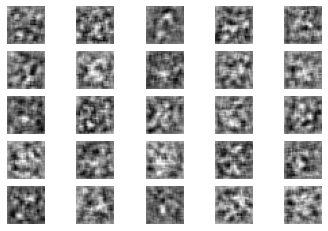

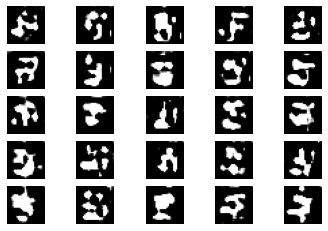

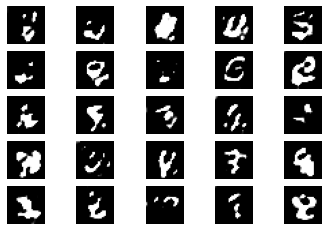

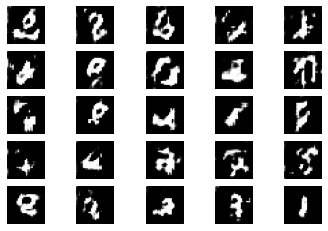

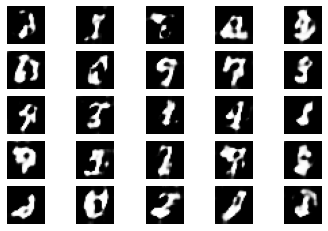

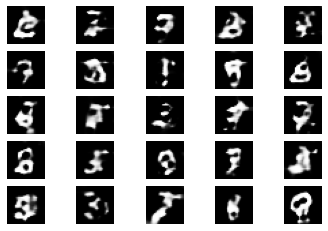

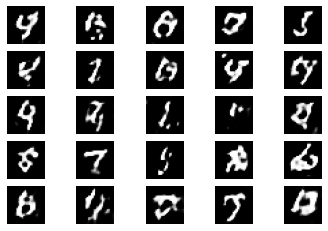

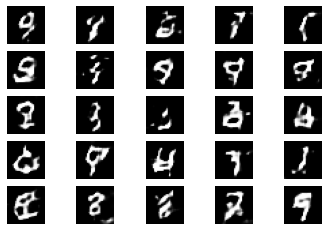

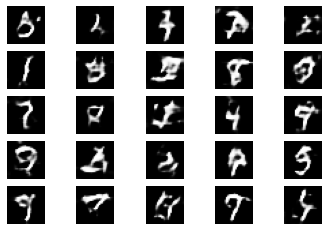

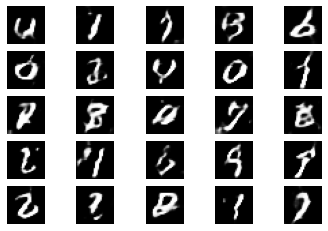

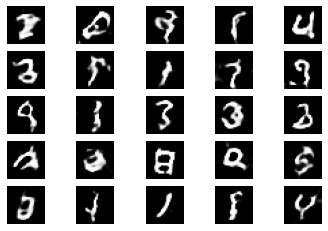

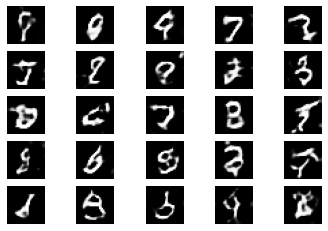

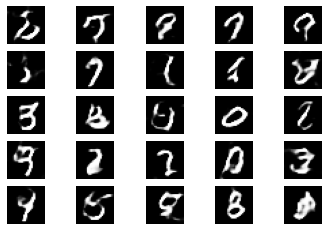

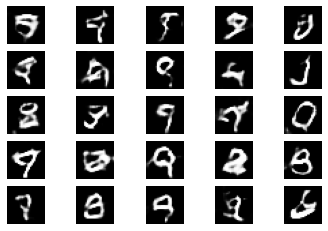

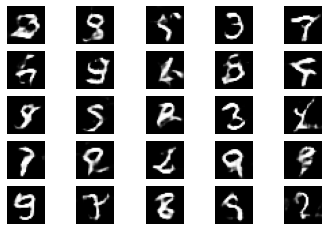

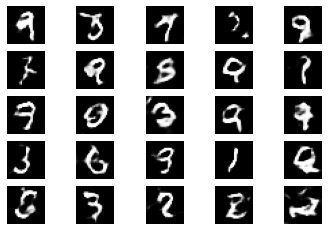

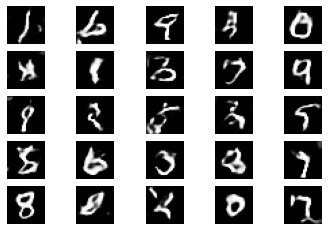

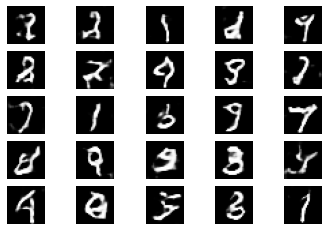

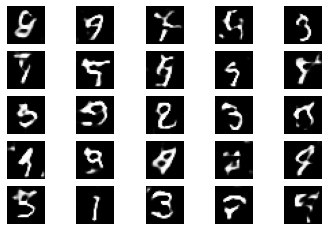

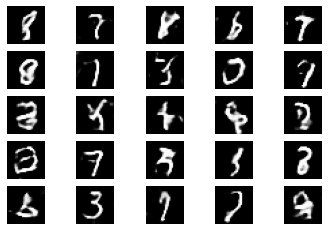

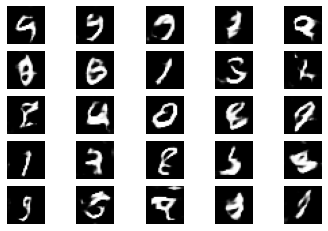

In [50]:
gan_train(4001, 32, 200)

### Auto Encoder

In [177]:
# mnist data 불러오기
(x_train, _), (x_test, _) = mnist.load_data() # train, test 이미지가 필요함????
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255

In [178]:
# 모델 생성
autoencoder = Sequential()

In [179]:
# 인코딩 부분
autoencoder.add(Conv2D(16, kernel_size = 3, padding = "same", input_shape = (28, 28, 1), 
                       activation = "relu"))
# 28 * 28 * 16
autoencoder.add(MaxPooling2D(2)) 
# 14 * 14 * 16
autoencoder.add(Conv2D(8, kernel_size = 3, activation = "relu", padding = "same")) 
# 14 * 14 * 8
autoencoder.add(MaxPooling2D(2)) 
# 7 * 7 * 8
autoencoder.add(Conv2D(8, kernel_size = 3, strides = 2, padding = "same", 
                       activation = "relu")) 
# 4 * 4 * 8

# 디코딩 부분
autoencoder.add(Conv2D(8, kernel_size = 3, padding = "same", activation = "relu")) 
# 4 * 4 * 8
autoencoder.add(UpSampling2D()) 
# 8 * 8 * 8
autoencoder.add(Conv2D(8, kernel_size = 3, padding = "same", activation = "relu")) 
# 8 * 8 * 8
autoencoder.add(UpSampling2D()) 
# 16 * 16 * 8
autoencoder.add(Conv2D(16, kernel_size = 3, activation = "relu")) 
# 14 * 14 * 16
autoencoder.add(UpSampling2D()) 
# 16 * 16 * 8
autoencoder.add(Conv2D(1, kernel_size = 3, padding = "same", activation = "sigmoid")) 
# 28 * 28 * 1

In [180]:
autoencoder.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_204 (Conv2D)         (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_205 (Conv2D)         (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_206 (Conv2D)         (None, 4, 4, 8)           584       
                                                                 
 conv2d_207 (Conv2D)         (None, 4, 4, 8)         

In [181]:
# compile
autoencoder.compile(optimizer = "adam", loss = "BCE")

In [183]:
# model 학습
autoencoder.fit(x_train, x_train, epochs = 30, batch_size = 128,
               validation_data = (x_test, x_test))

Epoch 1/30
469/469 [==============================] - 33s 70ms/step - loss: 0.2069 - val_loss: 0.1408
Epoch 2/30
469/469 [==============================] - 38s 81ms/step - loss: 0.1310 - val_loss: 0.1209
Epoch 3/30
469/469 [==============================] - 39s 83ms/step - loss: 0.1172 - val_loss: 0.1116
Epoch 4/30
469/469 [==============================] - 39s 83ms/step - loss: 0.1103 - val_loss: 0.1062
Epoch 5/30
469/469 [==============================] - 39s 84ms/step - loss: 0.1057 - val_loss: 0.1027
Epoch 6/30
469/469 [==============================] - 39s 83ms/step - loss: 0.1024 - val_loss: 0.0998
Epoch 7/30
469/469 [==============================] - 40s 85ms/step - loss: 0.1000 - val_loss: 0.0979
Epoch 8/30
469/469 [==============================] - 39s 84ms/step - loss: 0.0982 - val_loss: 0.0963
Epoch 9/30
469/469 [==============================] - 40s 84ms/step - loss: 0.0967 - val_loss: 0.0947
Epoch 10/30
469/469 [==============================] - 41s 88ms/step - loss: 0.095

In [206]:
# 테스트할 이미지를 5개만 가져옴
random_test = np.random.randint(x_test.shape[0], size = 5)

In [207]:
auto_image = autoencoder.predict(x_test) # autoencoder 이미지 생성

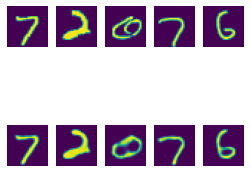

In [224]:
for i, image_idx in enumerate(random_test):
    ax = plt.subplot(2, 7, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    ax.axis("off")
    ax = plt.subplot(2, 7, 7 + i + 1)
    plt.imshow(auto_image[image_idx].reshape(28, 28))
    ax.axis("off")
plt.show()

### 전이 학습

In [259]:
# 훈련 이미지 확장
train_datagen = ImageDataGenerator(rescale = 1. /255,
                                  horizontal_flip = True,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
#                                   rotation_range=5,
#                                   shear_range=0.7,
#                                   zoom_range=[0.9, 2.2],
#                                   vertical_flip=True,                                   
                                  fill_mode = "nearest")

train_generator = train_datagen.flow_from_directory("./colab_train_test/train",
                                                   target_size = (150, 150),
                                                   batch_size = 5,
                                                   class_mode = "binary")

Found 160 images belonging to 2 classes.


In [260]:
# 테스트 이미지 확장
test_datagen = ImageDataGenerator(rescale = 1. /255)

test_generator = test_datagen.flow_from_directory("./colab_train_test/test",
                                                  target_size = (150, 150),
                                                  batch_size = 5,
                                                  class_mode = "binary")

Found 120 images belonging to 2 classes.


In [261]:
# CNN 모델 만들기
model = Sequential()
model.add(Conv2D(32, 3, input_shape = (150, 150, 3), activation = "relu"))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, 3, activation = "relu"))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(2, activation = "softmax"))

In [262]:
# 모델 컴파일
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002), metrics = "acc")

In [263]:
# 모델 실행
history = model.fit(train_generator, steps_per_epoch = 32, epochs = 20, 
                    validation_data = test_generator, validation_steps = 4)

Epoch 1/20
32/32 [==============================] - 2s 66ms/step - loss: 0.7345 - acc: 0.4938 - val_loss: 0.7092 - val_acc: 0.4000
Epoch 2/20
32/32 [==============================] - 2s 62ms/step - loss: 0.6903 - acc: 0.5063 - val_loss: 0.6653 - val_acc: 0.6500
Epoch 3/20
32/32 [==============================] - 2s 62ms/step - loss: 0.6826 - acc: 0.5500 - val_loss: 0.6598 - val_acc: 0.8000
Epoch 4/20
32/32 [==============================] - 2s 63ms/step - loss: 0.6724 - acc: 0.5562 - val_loss: 0.6624 - val_acc: 0.6500
Epoch 5/20
32/32 [==============================] - 2s 63ms/step - loss: 0.6605 - acc: 0.6062 - val_loss: 0.6258 - val_acc: 0.8000
Epoch 6/20
32/32 [==============================] - 2s 64ms/step - loss: 0.6985 - acc: 0.5375 - val_loss: 0.6805 - val_acc: 0.5500
Epoch 7/20
32/32 [==============================] - 2s 63ms/step - loss: 0.6545 - acc: 0.7063 - val_loss: 0.6307 - val_acc: 0.8000
Epoch 8/20
32/32 [==============================] - 2s 63ms/step - loss: 0.6194 - a

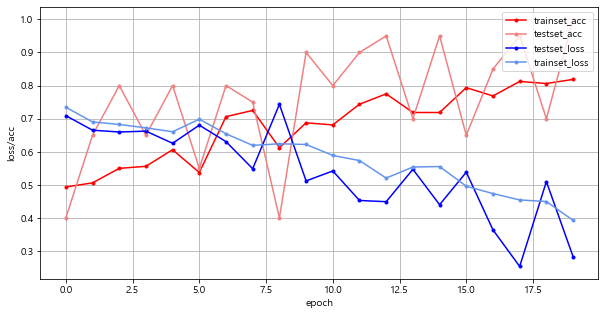

In [268]:
# 결과를 그래프로 표현
acc = history.history["acc"]
val_acc = history.history["val_acc"]
y_vloss = history.history["val_loss"]
y_loss = history.history["loss"]

x_len = np.arange(len(y_loss))

plt.figure(figsize = (10, 5))
plt.plot(x_len, acc, marker = ".", c = "red", label = "trainset_acc")
plt.plot(x_len, val_acc, marker = ".", c = "lightcoral", label = "testset_acc")
plt.plot(x_len, y_vloss, marker = ".", c = "blue", label = "testset_loss")
plt.plot(x_len, y_loss, marker = ".", c = "cornflowerblue", label = "trainset_loss")

plt.legend(loc = "upper right")
plt.xlabel("epoch")
plt.ylabel("loss/acc")
plt.grid()
plt.show()

### VGG16

In [271]:
from tensorflow.keras.applications import VGG16

In [272]:
# VGG16 사용
transfer_model = VGG16(weights = "imagenet", include_top = False, # imagenet 기본 값
                      input_shape = (150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

58900480/58889256 [==============================] - 86s 1us/step


In [274]:
# 아까 내 모델
model = Sequential()
model.add(transfer_model)
# model.add(Conv2D(32, 3, activation = "relu"))
# model.add(MaxPooling2D(2))
# model.add(Conv2D(32, 3, activation = "relu"))
# model.add(MaxPooling2D(2))
# 주석처리 한 부분이 transfer_model이고 transfer_model은 VGG16
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(2, activation = "softmax"))

In [275]:
# 아까 모델 컴파일
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002), metrics = "acc")

In [276]:
# 아까 모델 실행
history = model.fit(train_generator, steps_per_epoch = 32, epochs = 20, 
                    validation_data = test_generator, validation_steps = 4)

Epoch 1/20
32/32 [==============================] - 13s 379ms/step - loss: 0.8223 - acc: 0.4750 - val_loss: 0.5794 - val_acc: 0.7500
Epoch 2/20
32/32 [==============================] - 13s 402ms/step - loss: 0.5495 - acc: 0.7063 - val_loss: 0.4968 - val_acc: 0.8500
Epoch 3/20
32/32 [==============================] - 14s 441ms/step - loss: 0.4318 - acc: 0.8500 - val_loss: 0.3419 - val_acc: 0.9000
Epoch 4/20
32/32 [==============================] - 19s 601ms/step - loss: 0.3639 - acc: 0.8875 - val_loss: 0.2735 - val_acc: 0.8500
Epoch 5/20
32/32 [==============================] - 18s 570ms/step - loss: 0.2885 - acc: 0.9125 - val_loss: 0.3671 - val_acc: 0.9000
Epoch 6/20
32/32 [==============================] - 17s 529ms/step - loss: 0.2466 - acc: 0.9563 - val_loss: 0.3352 - val_acc: 0.9000
Epoch 7/20
32/32 [==============================] - 17s 546ms/step - loss: 0.2296 - acc: 0.9375 - val_loss: 0.2094 - val_acc: 0.9500
Epoch 8/20
32/32 [==============================] - 17s 518ms/step - 

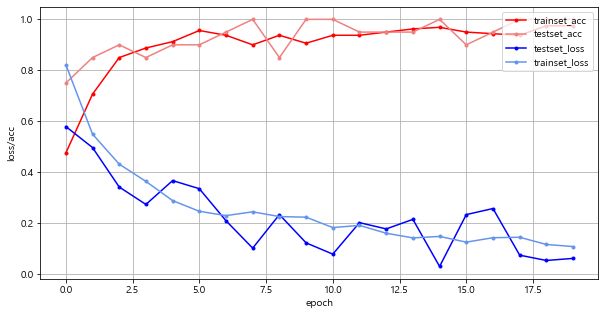

In [277]:
# VGG16이랑 붙인거 결과를 그래프로 표현
acc = history.history["acc"]
val_acc = history.history["val_acc"]
y_vloss = history.history["val_loss"]
y_loss = history.history["loss"]

x_len = np.arange(len(y_loss))

plt.figure(figsize = (10, 5))
plt.plot(x_len, acc, marker = ".", c = "red", label = "trainset_acc")
plt.plot(x_len, val_acc, marker = ".", c = "lightcoral", label = "testset_acc")
plt.plot(x_len, y_vloss, marker = ".", c = "blue", label = "testset_loss")
plt.plot(x_len, y_loss, marker = ".", c = "cornflowerblue", label = "trainset_loss")

plt.legend(loc = "upper right")
plt.xlabel("epoch")
plt.ylabel("loss/acc")
plt.grid()
plt.show()

맺음말<br>
이제 남은 일은, 스스로의 데이터를 찾아서 이를 활용해 보는 것<br>
캐글 등에서 더 많고 다양한 데이터를 내려받을 수 있고,<br>
새로운 논문이나 깃허브 검색으로 최신 방법들을 실행하고 분석할 수도 있음<br>
<br>
데이터 전처리<br>
지도학습인 경우 x, target<br>
비지도 학습일 경우 X가 있고 분류를 알아서<br>
데이터의 특징<br>
이미지 = cnn<br>
text = rnn -> LSTM/GRU<br>
GAN 이미지 생성<br>
autoencoder 이미지<br>